In [1]:
from preamble import *
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn

## Algorithm Chains and Pipelines

 In particular, we will see
how we can combine Pipeline and GridSearchCV to search over parameters for all
processing steps at once.

In [3]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# load and split the data
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)

In [4]:
# rescale the training data
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# learn an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)
# scale the test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score: 0.97


### Parameter Selection with Preprocessing 

Now let’s say we want to find better parameters for SVC using GridSearchCV, as dis‐
cussed in Chapter 5. How should we go about doing this? A naive approach might
look like this:

In [5]:
from sklearn.model_selection import GridSearchCV
# for illustration purposes only, don't use this code!
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Test set accuracy: {:.2f}".format(grid.score(X_test_scaled, y_test)))

Best cross-validation accuracy: 0.98
Best parameters:  {'C': 1, 'gamma': 1}
Test set accuracy: 0.97


Here, we ran the grid search over the parameters of SVC using the scaled data. How‐
ever, there is a subtle catch in what we just did. When scaling the data, we used all the
data in the training set to find out how to train it. We then use the scaled training data
to run our grid search using cross-validation. For each split in the cross-validation,
some part of the original training set will be declared the training part of the split,
and some the test part of the split. The test part is used to measure what new data will
look like to a model trained on the training part. However, we already used the infor‐
mation contained in the test part of the split, when scaling the data. Remember that
the test part in each split in the cross-validation is part of the training set, and we
used the information from the entire training set to find the right scaling of the data.


is is fundamentally different from how new data looks to the model. If we observe
new data (say, in form of our test set), this data will not have been used to scale the
training data, and it might have a different minimum and maximum than the train‐
ing data. The following example (Figure 6-1) shows how the data processing during
cross-validation and the final evaluation differ:

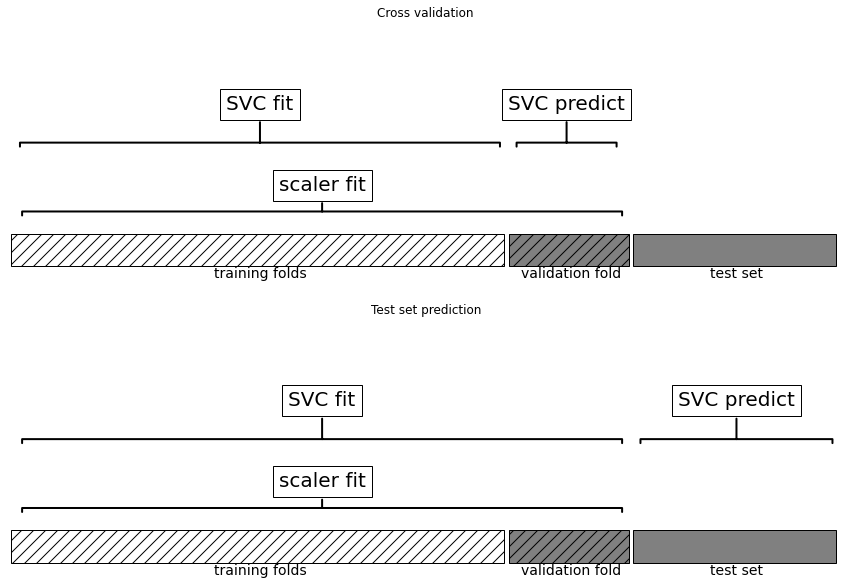

In [6]:
mglearn.plots.plot_improper_processing()

So, the splits in the cross-validation no longer correctly mirror how new data will
look to the modeling process. We already leaked information from these parts of the
data into our modeling process. This will lead to overly optimistic results during
cross-validation, and possibly the selection of suboptimal parameters.

To get around this problem, the splitting of the dataset during cross-validation should
be done before doing any preprocessing. Any process that extracts knowledge from the
dataset should only ever be applied to the training portion of the dataset, so any
cross-validation should be the “outermost loop” in your processing.

To achieve this in scikit-learn with the cross_val_score function and the Grid
SearchCV function, we can use the Pipeline class. The Pipeline class is a class that
allows “gluing” together multiple processing steps into a single scikit-learn estimator.


The Pipeline class itself has fit, predict, and score methods and behaves just
like any other model in scikit-learn. The most common use case of the Pipeline
class is in chaining preprocessing steps (like scaling of the data) together with a
supervised model like a classifier.

### Building Pipelines

Let’s look at how we can use the Pipeline class to express the workflow for training
an SVM after scaling the data with MinMaxScaler (for now without the grid search).
First, we build a pipeline object by providing it with a list of steps. Each step is a tuple
containing a name (any string of your choosing1
) and an instance of an estimator:

In [7]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

Here, we created two steps: the first, called "scaler", is an instance of MinMaxScaler,
and the second, called "svm", is an instance of SVC. Now, we can fit the pipeline, like
any other scikit-learn estimator:

In [8]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

. To evaluate on
the test data, we simply call pipe.score:

In [9]:
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.97


Calling the score method on the pipeline first transforms the test data using the
scaler, and then calls the score method on the SVM using the scaled test data.


Using the pipeline, we reduced the
code needed for our “preprocessing + classification” process. The main benefit of
using the pipeline, however, is that we can now use this single estimator in
cross_val_score or GridSearchCV.

### Using Pipelines in Grid-searches

We need to specify for each parameter which step of the pipeline it
belongs to. Both parameters that we want to adjust, C and gamma, are parameters of
SVC, the second step. We gave this step the name "svm". The syntax to define a param‐
eter grid for a pipeline is to specify for each parameter the step name, followed by __
(a double underscore), followed by the parameter name. To search over the C param‐
eter of SVC we therefore have to use "svm__C" as the key in the parameter grid dictio‐
nary, and similarly for gamma:

In [10]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

With this parameter grid we can use GridSearchCV as usual:

In [11]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


In contrast to the grid search we did before, now for each split in the cross-validation,
the MinMaxScaler is refit with only the training splits and no information is leaked
from the test split into the parameter search

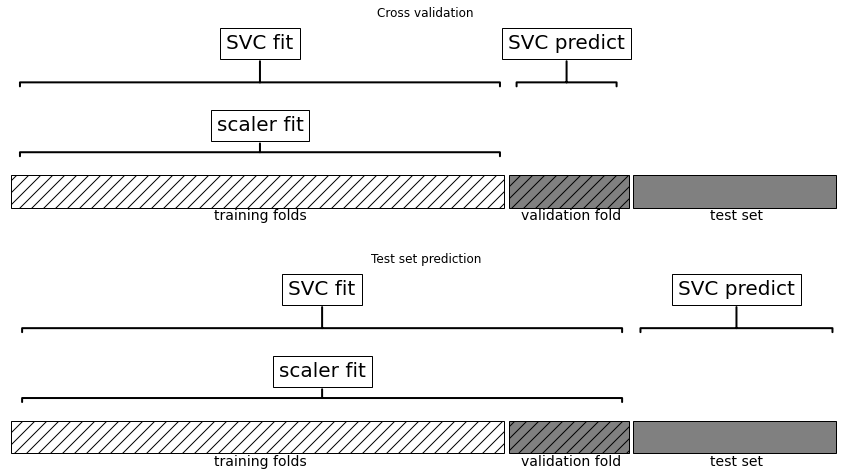

In [13]:
mglearn.plots.plot_proper_processing()

In [14]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

Given the way we created the dataset, there is no relation between the data, X, and the
target, y (they are independent), so it should not be possible to learn anything from
this dataset. We will now do the following. First, select the most informative of the 10
features using SelectPercentile feature selection, and then we evaluate a Ridge
regressor using cross-validation:

In [15]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("X_selected.shape: {}".format(X_selected.shape))

X_selected.shape: (100, 500)


In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("Cross-validation accuracy (cv only on ridge): {:.2f}".format(
      np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

Cross-validation accuracy (cv only on ridge): 0.91


The mean R
2
 computed by cross-validation is 0.91, indicating a very good model.
This clearly cannot be right, as our data is entirely random. What happened here is
that our feature selection picked out some features among the 10,000 random features
that are (by chance) very well correlated with the target. Because we fit the feature
selection outside of the cross-validation, it could find features that are correlated both
on the training and the test folds. The information we leaked from the test folds was
very informative, leading to highly unrealistic results. Let’s compare this to a proper
cross-validation using a pipeline:

In [17]:
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression,
                                             percentile=5)),
                 ("ridge", Ridge())])
print("Cross-validation accuracy (pipeline): {:.2f}".format(
      np.mean(cross_val_score(pipe, X, y, cv=5))))

Cross-validation accuracy (pipeline): -0.25


This time, we get a negative R
2
 score, indicating a very poor model. Using the pipe‐
line, the feature selection is now inside the cross-validation loop. This means features
can only be selected using the training folds of the data, not the test fold. The feature
selection finds features that are correlated with the target on the training set, but
because the data is entirely random, these features are not correlated with the target
on the test set. In this example, rectifying the data leakage issue in the feature selec‐
tion makes the difference between concluding that a model works very well and con‐
cluding that a model works not at all.

### The General Pipeline Interface

The Pipeline class is not restricted to preprocessing and classification, but can in
fact join any number of estimators together. For example, you could build a pipeline
containing feature extraction, feature selection, scaling, and classification, for a total
of four steps. Similarly, the last step could be regression or clustering instead of classi‐
fication.

The only requirement for estimators in a pipeline is that all but the last step need to
have a transform method, so they can produce a new representation of the data that
can be used in the next step.

Remember that pipe
line.steps is a list of tuples, so pipeline.steps[0][1] is the first estimator, pipe
line.steps[1][1] is the second estimator, and so on:

In [18]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # iterate over all but the final step
        # fit and transform the data
        X_transformed = estimator.fit_transform(X_transformed, y)
        # fit the last step
    self.steps[-1][1].fit(X_transformed, y)
    return self

The pipeline is actually even more general than this. There is no requirement for the
last step in a pipeline to have a predict function, and we could create a pipeline just
containing, for example, a scaler and PCA. Then, because the last step (PCA) has a
transform method, we could call transform on the pipeline to get the output of
PCA.transform applied to the data that was processed by the previous step. The last
step of a pipeline is only required to have a fit method.


Creating a pipeline using the syntax described earlier is sometimes a bit cumbersome,
and we often don’t need user-specified names for each step. There is a convenience
function, make_pipeline, that will create a pipeline for us and automatically name
each step based on its class. The syntax for make_pipeline is as follows:

In [19]:
from sklearn.pipeline import make_pipeline
# standard syntax
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# abbreviated syntax
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

The pipeline objects pipe_long and pipe_short do exactly the same thing, but
pipe_short has steps that were automatically named. We can see the names of the
steps by looking at the steps attribute:

In [20]:
print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


The steps are named minmaxscaler and svc. In general, the step names are just low‐
ercase versions of the class names. If multiple steps have the same class, a number is
appended:

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("Pipeline steps:\n{}".format(pipe.steps))

Pipeline steps:
[('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


Often you will want to inspect attributes of one of the steps of the pipeline—say, the
coefficients of a linear model or the components extracted by PCA. The easiest way to
access the steps in a pipeline is via the named_steps attribute, which is a dictionary
from the step names to the estimators:

In [22]:
# fit the pipeline defined before to the cancer dataset
pipe.fit(cancer.data)
# extract the first two principal components from the "pca" step
components = pipe.named_steps["pca"].components_
print("components.shape: {}".format(components.shape))

components.shape: (2, 30)


As we discussed earlier in this chapter, one of the main reasons to use pipelines is for
doing grid searches. A common task is to access some of the steps of a pipeline inside
a grid search. Let’s grid search a LogisticRegression classifier on the cancer dataset,
using Pipeline and StandardScaler to scale the data before passing it to the Logisti
cRegression classifier. First we create a pipeline using the make_pipeline function:

In [23]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(StandardScaler(), LogisticRegression())

param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}Next, we create a parameter grid. As explained in Chapter 2, the regularization
parameter to tune for LogisticRegression is the parameter C. We use a logarithmic
grid for this parameter, searching between 0.01 and 100. Because we used the
make_pipeline function, the name of the LogisticRegression step in the pipeline is
the lowercased class name, logisticregression. To tune the parameter C, we there‐
fore have to specify a parameter grid for logisticregression__C:

In [24]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

As usual, we split the cancer dataset into training and test sets, and fit a grid search:

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
 cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

So how do we access the coefficients of the best LogisticRegression model that was
found by GridSearchCV? From Chapter 5 we know that the best model found by
GridSearchCV, trained on all the training data, is stored in grid.best_estimator_:

In [26]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1))])


This best_estimator_ in our case is a pipeline with two steps, standardscaler and
logisticregression. To access the logisticregression step, we can use the
named_steps attribute of the pipeline, as explained earlier:

In [27]:
print("Logistic regression step:\n{}".format(
 grid.best_estimator_.named_steps["logisticregression"]))

Logistic regression step:
LogisticRegression(C=1)


Now that we have the trained LogisticRegression instance, we can access the coeffi‐
cients (weights) associated with each input feature:

In [28]:
print("Logistic regression coefficients:\n{}".format(
 grid.best_estimator_.named_steps["logisticregression"].coef_))

Logistic regression coefficients:
[[-0.436 -0.343 -0.408 -0.534 -0.15   0.61  -0.726 -0.785  0.039  0.275
  -1.298  0.049 -0.673 -0.934 -0.139  0.45  -0.13  -0.101  0.434  0.716
  -1.091 -1.095 -0.852 -1.064 -0.743  0.073 -0.823 -0.653 -0.644 -0.42 ]]


Using pipelines, we can encapsulate all the processing steps in our machine learning
workflow in a single scikit-learn estimator. Another benefit of doing this is that we
can now adjust the parameters of the preprocessing using the outcome of a supervised
task like regression or classification. In previous chapters, we used polynomial fea‐
tures on the boston dataset before applying the ridge regressor. Let’s model that using
a pipeline instead. The pipeline contains three steps—scaling the data, computing
polynomial features, and ridge regression:

In [29]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
 random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
 StandardScaler(),
 PolynomialFeatures(),
 Ridge())

How do we know which degrees of polynomials to choose, or whether to choose any
polynomials or interactions at all? Ideally we want to select the degree parameter
based on the outcome of the classification. Using our pipeline, we can search over the
degree parameter together with the parameter alpha of Ridge. To do this, we define a
param_grid that contains both, appropriately prefixed by the step names:

In [30]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
 'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

Now we can run our grid search again:

In [31]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

We can visualize the outcome of the cross-validation using a heat map (Figure 6-4), as
we did in Chapter 5:

([<matplotlib.axis.YTick at 0x7ff55b439d00>,
 [Text(0, 0, '1'), Text(0, 1, '2'), Text(0, 2, '3')])

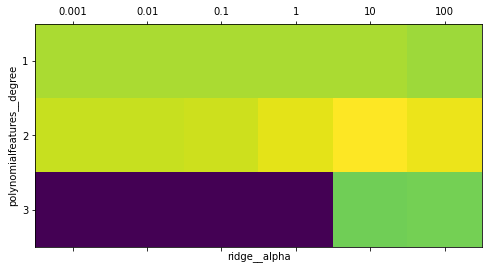

In [32]:
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1),
 vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")

plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),
 param_grid['polynomialfeatures__degree'])

Looking at the results produced by the cross-validation, we can see that using polyno‐
mials of degree two helps, but that degree-three polynomials are much worse than
either degree one or two. This is reflected in the best parameters that were found:

In [33]:
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [34]:
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Test-set score: 0.77


Let’s run a grid search without polynomial features for comparison:

In [35]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Score without poly features: {:.2f}".format(grid.score(X_test, y_test)))

Score without poly features: 0.63


Searching over preprocessing parameters together with model parameters is a very
powerful strategy. However, keep in mind that GridSearchCV tries all possible combi‐
nations of the specified parameters. Therefore, adding more parameters to your grid
exponentially increases the number of models that need to be built.

## Grid-Searching Which Model To Use

You can even go further in combining GridSearchCV and Pipeline: it is also possible
to search over the actual steps being performed in the pipeline (say whether to use
StandardScaler or MinMaxScaler). This leads to an even bigger search space and
should be considered carefully. Trying all possible solutions is usually not a viable
machine learning strategy. However, here is an example comparing a RandomForest
Classifier and an SVC on the iris dataset. We know that the SVC might need the
data to be scaled, so we also search over whether to use StandardScaler or no pre‐
processing. For the RandomForestClassifier, we know that no preprocessing is nec‐
essary. We start by defining the pipeline. Here, we explicitly name the steps. We want
two steps, one for the preprocessing and then a classifier. We can instantiate this
using SVC and StandardScaler:

In [36]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

Now we can define the parameter_grid to search over. We want the classifier to
be either RandomForestClassifier or SVC. Because they have different parameters to
tune, and need different preprocessing, we can make use of the list of search grids we
discussed in “Search over spaces that are not grids” on page 271. To assign an estima‐
tor to a step, we use the name of the step as the parameter name. When we wanted to
skip a step in the pipeline (for example, because we don’t need preprocessing for the
RandomForest), we can set that step to None:

In [37]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
 {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
 'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
 'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
 {'classifier': [RandomForestClassifier(n_estimators=100)],
 'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

Now we can instantiate and run the grid search as usual, here on the cancer dataset:

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
 cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

Best cross-validation score: 0.99
Test-set score: 0.98


The outcome of the grid search is that SVC with StandardScaler preprocessing, C=10,
and gamma=0.01 gave the best result.

The Pipeline class also
allows writing more succinct code, and reduces the likelihood of mistakes that can
happen when building processing chains without the pipeline class (like forgetting
to apply all transformers on the test set, or not applying them in the right order).

In [16]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # iterate over all but the final step
        # fit and transform the data
        X_transformed = estimator.fit_transform(X_transformed, y)
    # fit the last step
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [17]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # iterate over all but the final step
        # transform the data
        X_transformed = step[1].transform(X_transformed)
    # predict using the last step
    return self.steps[-1][1].predict(X_transformed)

![pipeline_illustration](images/pipeline.png)

### Convenient Pipeline creation with ``make_pipeline``

In [18]:
from sklearn.pipeline import make_pipeline
# standard syntax
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# abbreviated syntax
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [19]:
print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("Pipeline steps:\n{}".format(pipe.steps))

Pipeline steps:
[('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


#### Accessing step attributes

In [21]:
# fit the pipeline defined before to the cancer dataset
pipe.fit(cancer.data)
# extract the first two principal components from the "pca" step
components = pipe.named_steps["pca"].components_
print("components.shape: {}".format(components.shape))

components.shape: (2, 30)


#### Accessing Attributes in a Pipeline inside GridSearchCV

In [22]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

In [23]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

In [25]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1, max_iter=1000))])


In [26]:
print("Logistic regression step:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"]))

Logistic regression step:
LogisticRegression(C=1, max_iter=1000)


In [27]:
print("Logistic regression coefficients:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"].coef_))

Logistic regression coefficients:
[[-0.436 -0.343 -0.408 -0.534 -0.15   0.61  -0.726 -0.785  0.039  0.275
  -1.298  0.049 -0.673 -0.934 -0.139  0.45  -0.13  -0.101  0.434  0.716
  -1.091 -1.095 -0.852 -1.064 -0.743  0.073 -0.823 -0.653 -0.644 -0.42 ]]


### Grid-searching preprocessing steps and model parameters

In [28]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

In [29]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [30]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

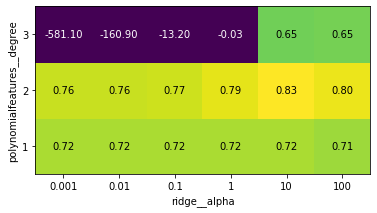

In [31]:
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3, -1),
                      xlabel="ridge__alpha", ylabel="polynomialfeatures__degree",
                      xticklabels=param_grid['ridge__alpha'],
                      yticklabels=param_grid['polynomialfeatures__degree'], vmin=0)

In [32]:
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [33]:
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Test-set score: 0.77


In [34]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Score without poly features: {:.2f}".format(grid.score(X_test, y_test)))

Score without poly features: 0.63


In [35]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [36]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

Best cross-validation score: 0.99
Test-set score: 0.98


#### Avoiding Redundant Computation

In [38]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())],
                memory="cache_folder")

### Summary and Outlook